In [35]:
import pandas as pd

In [36]:
df = pd.read_csv('survey.csv')

In [38]:
df.columns

Index(['Select your year group:',
       'Which AI platforms or tools have you used for schoolwork or homework? (Select all that apply)',
       'How often do you use AI tools for academic work?',
       'For which subjects do you most commonly use AI tools? (Select all that apply)',
       'How do you typically use AI tools for your schoolwork? (Select all that apply)',
       'When you use AI for homework, do you typically:',
       'How do you feel about using AI tools for schoolwork?',
       'How confident are you in your ability to use AI tools effectively and ethically?',
       'Do you currently declare when you've used AI tools in your homework or assignments?',
       'How aware do you think your teachers are of your AI usage?',
       'How do you feel about teachers using AI in their teaching, e.g. when preparing resources for lessons?',
       'What support would be most helpful from school regarding AI use? (Select up to 3)',
       'Have you ever been unsure whether your 

In [39]:
df = df.rename(columns={"Select your year group:": "Year",
                        "Which AI platforms or tools have you used for schoolwork or homework? (Select all that apply)": "Tools",
                        "How often do you use AI tools for academic work?": "Occurrence",
                        "For which subjects do you most commonly use AI tools? (Select all that apply)": "Subjects",
                        "How do you typically use AI tools for your schoolwork? (Select all that apply)": "Reasons",
                        "When you use AI for homework, do you typically:": "Scenario",
                        "How do you feel about using AI tools for schoolwork?": "Feeling",
                        "How confident are you in your ability to use AI tools effectively and ethically?": "Confidence",
                        "Do you currently declare when you've used AI tools in your homework or assignments?": "Declare",
                        "How aware do you think your teachers are of your AI usage?": "Teacher_awareness",
                        "How do you feel about teachers using AI in their teaching, e.g. when preparing resources for lessons?": "Teacher_usage",
                        "What support would be most helpful from school regarding AI use? (Select up to 3)": "Support",
                        "Have you ever been unsure whether your use of AI was appropriate for a particular assignment or task?": "Allowed",
                        "How did you first learn about using AI tools for schoolwork?": "Discovery",
                        "Do you primarily use AI tools on:": "Device",
                        "Are your parents/guardians aware that you use AI tools for schoolwork?": "Parent_awareness",
                        "What has prevented you from using AI tools more, or what concerns do you have? (Select all that apply)": "Concerns",
                        "Is there anything else you'd like us to know about your experience with AI tools, or suggestions for how the school could better support students in this area?": "Other_info"
               })

In [41]:
# examine our key variables first
for col in ['Occurrence', 'Declare', 'Parent_awareness', 'Subjects']:
    print(f"\n=== {col} ===")
    print(df[col].value_counts())
    print(f"Missing values: {df[col].isnull().sum()}")


=== Occurrence ===
Occurrence
Rarely                  133
Never                    45
Weekly                   37
Monthly                  32
Several times a week     16
Daily                    10
Name: count, dtype: int64
Missing values: 0

=== Declare ===
Declare
I'm not sure if I'm supposed to    104
Never                               52
Always                              34
Sometimes                           32
Rarely                              28
Usually                             23
Name: count, dtype: int64
Missing values: 0

=== Parent_awareness ===
Parent_awareness
Yes, they know but don't have strong opinions    71
Not applicable - I don't use AI tools            71
Yes, they know and are supportive                62
I'm not sure if they know                        56
Yes, they know but have concerns                 10
No, they don't know                               3
Name: count, dtype: int64
Missing values: 0

=== Subjects ===
Subjects
Modern Foreign Languages;   

In [42]:
df['Subjects'].unique()

array(['Modern Foreign Languages;Humanities;', 'politics;',
       'Mathematics;Sciences (Biology, Chemistry, Physics);Computer Science;',
       'Sciences (Biology, Chemistry, Physics);Organisation;', 'N/.A;',
       'Humanities;',
       'Sciences (Biology, Chemistry, Physics);Mathematics;',
       ' English/Literature;Sciences (Biology, Chemistry, Physics);Humanities;',
       'Mathematics;Modern Foreign Languages;',
       ' English/Literature;Mathematics;', ' English/Literature;',
       'Mathematics;', 'none;', 'N/A;',
       'Modern Foreign Languages;Computer Science;',
       'Modern Foreign Languages;',
       ' English/Literature;Modern Foreign Languages;',
       'Humanities; English/Literature;',
       'Sciences (Biology, Chemistry, Physics);',
       ' English/Literature;Mathematics;Sciences (Biology, Chemistry, Physics);',
       ' English/Literature;Mathematics;Modern Foreign Languages;',
       'Computer Science; English/Literature;Mathematics;',
       ' English/Liter

In [43]:
# encode occurrence column
def encode_occurrence(value):
    occurrence_map = {
        'Daily': 5,
        'Several times a week': 4,
        'Weekly': 3,
        'Monthly': 2,
        'Rarely': 1,
        'Never': 0
    }
    return occurrence_map[value]


In [44]:
def encode_declare(value):
    declare_map = {
        'Always': 5,
        'Usually': 4,
        'Sometimes': 3,
        'Rarely': 2,
        "I'm not sure if I'm supposed to": 1,
        'Never': 0
    }
    return declare_map[value]

In [45]:
def encode_parent_awareness(value):
    parent_map = {
        'Yes, they know and are supportive': 3,
        'Yes, they know but don\'t have strong opinions': 3,
        'Yes, they know but have concerns': 3,
        "I'm not sure if they know": 2,
        "No, they don't know": 1,
        "Not applicable - I don't use AI tools": 0
    }
    return parent_map[value]

In [46]:
def count_subjects(value):
    if pd.isna(value) or value.strip() == '':
        return 0
    
    value_lower = value.lower().strip()
    
    # Clear "don't use" patterns
    dont_use_patterns = [
        "i don't use ai", "i dont use ai", "i do not use ai",
        "i don't use it", "i dont use it", 
        "never use", "dont use it",
        "i don't;", "i dont;", "i don't ", "i dont ",
        "never;", "none;", "n/a;", "n/.a;"
    ]
    
    if any(pattern in value_lower for pattern in dont_use_patterns):
        return 0
    
    if value.strip() in [';', ' ;', '']:
        return 0
    
    # Special cases that indicate usage
    usage_indicators = [
        "practice questions", "revision", "timetable", "flashcard", 
        "autocorrect", "translate", "understand", "grammer", "grammar"
    ]
    
    if any(indicator in value_lower for indicator in usage_indicators):
        return 1
    
    return value.count(';')

In [48]:
# Apply transformations
df['occurrence_encoded'] = df['Occurrence'].apply(encode_occurrence)
df['declare_encoded'] = df['Declare'].apply(encode_declare)
df['parent_awareness_encoded'] = df['Parent_awareness'].apply(encode_parent_awareness)
df['subject_count'] = df['Subjects'].apply(count_subjects)

# Create clustering dataset
clustering_data = df[['occurrence_encoded', 'subject_count', 'declare_encoded', 'parent_awareness_encoded']].copy()

print("Clustering dataset created!")
print(f"Shape: {clustering_data.shape}")
print(f"\nData types:\n{clustering_data.dtypes}")
print(f"\nBasic statistics:\n{clustering_data.describe()}")
print(f"\nFirst 10 rows:\n{clustering_data.head(10)}")

Clustering dataset created!
Shape: (273, 4)

Data types:
occurrence_encoded          int64
subject_count               int64
declare_encoded             int64
parent_awareness_encoded    int64
dtype: object

Basic statistics:
       occurrence_encoded  subject_count  declare_encoded  \
count          273.000000     273.000000       273.000000   
mean             1.545788       1.380952         1.897436   
std              1.282916       1.095413         1.648449   
min              0.000000       0.000000         0.000000   
25%              1.000000       1.000000         1.000000   
50%              1.000000       1.000000         1.000000   
75%              2.000000       2.000000         3.000000   
max              5.000000       8.000000         5.000000   

       parent_awareness_encoded  
count                273.000000  
mean                   1.992674  
std                    1.257310  
min                    0.000000  
25%                    0.000000  
50%                 

In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Standardise the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

print("Original data shape:", clustering_data.shape)
print("Scaled data shape:", clustering_data_scaled.shape)
print("\nOriginal data ranges:")
print(clustering_data.describe())
print("\nScaled data mean (should be ~0):")
print(clustering_data_scaled.mean(axis=0))
print("Scaled data std (should be ~1):")
print(clustering_data_scaled.std(axis=0))

Original data shape: (273, 4)
Scaled data shape: (273, 4)

Original data ranges:
       occurrence_encoded  subject_count  declare_encoded  \
count          273.000000     273.000000       273.000000   
mean             1.545788       1.380952         1.897436   
std              1.282916       1.095413         1.648449   
min              0.000000       0.000000         0.000000   
25%              1.000000       1.000000         1.000000   
50%              1.000000       1.000000         1.000000   
75%              2.000000       2.000000         3.000000   
max              5.000000       8.000000         5.000000   

       parent_awareness_encoded  
count                273.000000  
mean                   1.992674  
std                    1.257310  
min                    0.000000  
25%                    0.000000  
50%                    3.000000  
75%                    3.000000  
max                    3.000000  

Scaled data mean (should be ~0):
[-7.80816193e-17  3.25340080e

C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmea

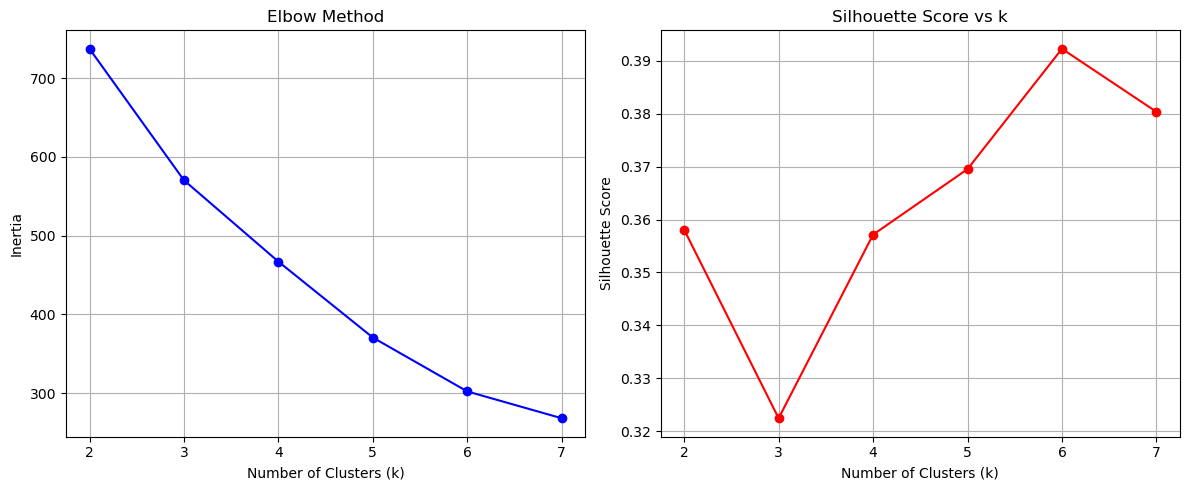

Silhouette scores for different k:
k=2: 0.358
k=3: 0.322
k=4: 0.357
k=5: 0.370
k=6: 0.392
k=7: 0.380


In [51]:
# Test different numbers of clusters
k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data_scaled, kmeans.labels_))

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs k')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Silhouette scores for different k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

In [69]:
# Fit final K-means with k=4
final_kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(clustering_data_scaled)

# Add cluster labels to our original data
df['cluster'] = cluster_labels
clustering_data['cluster'] = cluster_labels

print(f"Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0     47
1     67
2    132
3     27
Name: count, dtype: int64


C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [70]:
# Analyse each cluster's characteristics
cluster_analysis = clustering_data.groupby('cluster').agg({
    'occurrence_encoded': ['mean', 'std'],
    'subject_count': ['mean', 'std'], 
    'declare_encoded': ['mean', 'std'],
    'parent_awareness_encoded': ['mean', 'std']
}).round(2)

print("Cluster Characteristics (Original Scale):")
print(cluster_analysis)

print("\n" + "="*60)
print("CLUSTER INTERPRETATION:")
print("="*60)

for cluster_id in range(4):
    cluster_data = clustering_data[clustering_data['cluster'] == cluster_id]
    print(f"\n🔍 CLUSTER {cluster_id} (n={len(cluster_data)}):")
    print(f"  • Usage Frequency: {cluster_data['occurrence_encoded'].mean():.1f} (0=Never, 5=Daily)")
    print(f"  • Number of Subjects: {cluster_data['subject_count'].mean():.1f}")
    print(f"  • School Disclosure: {cluster_data['declare_encoded'].mean():.1f} (0=Never, 5=Always)")
    print(f"  • Parent Awareness: {cluster_data['parent_awareness_encoded'].mean():.1f} (0=N/A, 3=Yes)")

Cluster Characteristics (Original Scale):
        occurrence_encoded       subject_count       declare_encoded        \
                      mean   std          mean   std            mean   std   
cluster                                                                      
0                     0.53  0.69          0.57  0.65            0.55  0.65   
1                     3.45  0.88          2.18  1.41            1.70  1.39   
2                     1.14  0.48          1.41  0.72            1.92  1.49   
3                     0.56  0.51          0.67  0.88            4.63  0.63   

        parent_awareness_encoded        
                            mean   std  
cluster                                 
0                           0.06  0.25  
1                           2.72  0.55  
2                           2.70  0.46  
3                           0.07  0.38  

CLUSTER INTERPRETATION:

🔍 CLUSTER 0 (n=47):
  • Usage Frequency: 0.5 (0=Never, 5=Daily)
  • Number of Subjects: 0.6
  • Sc

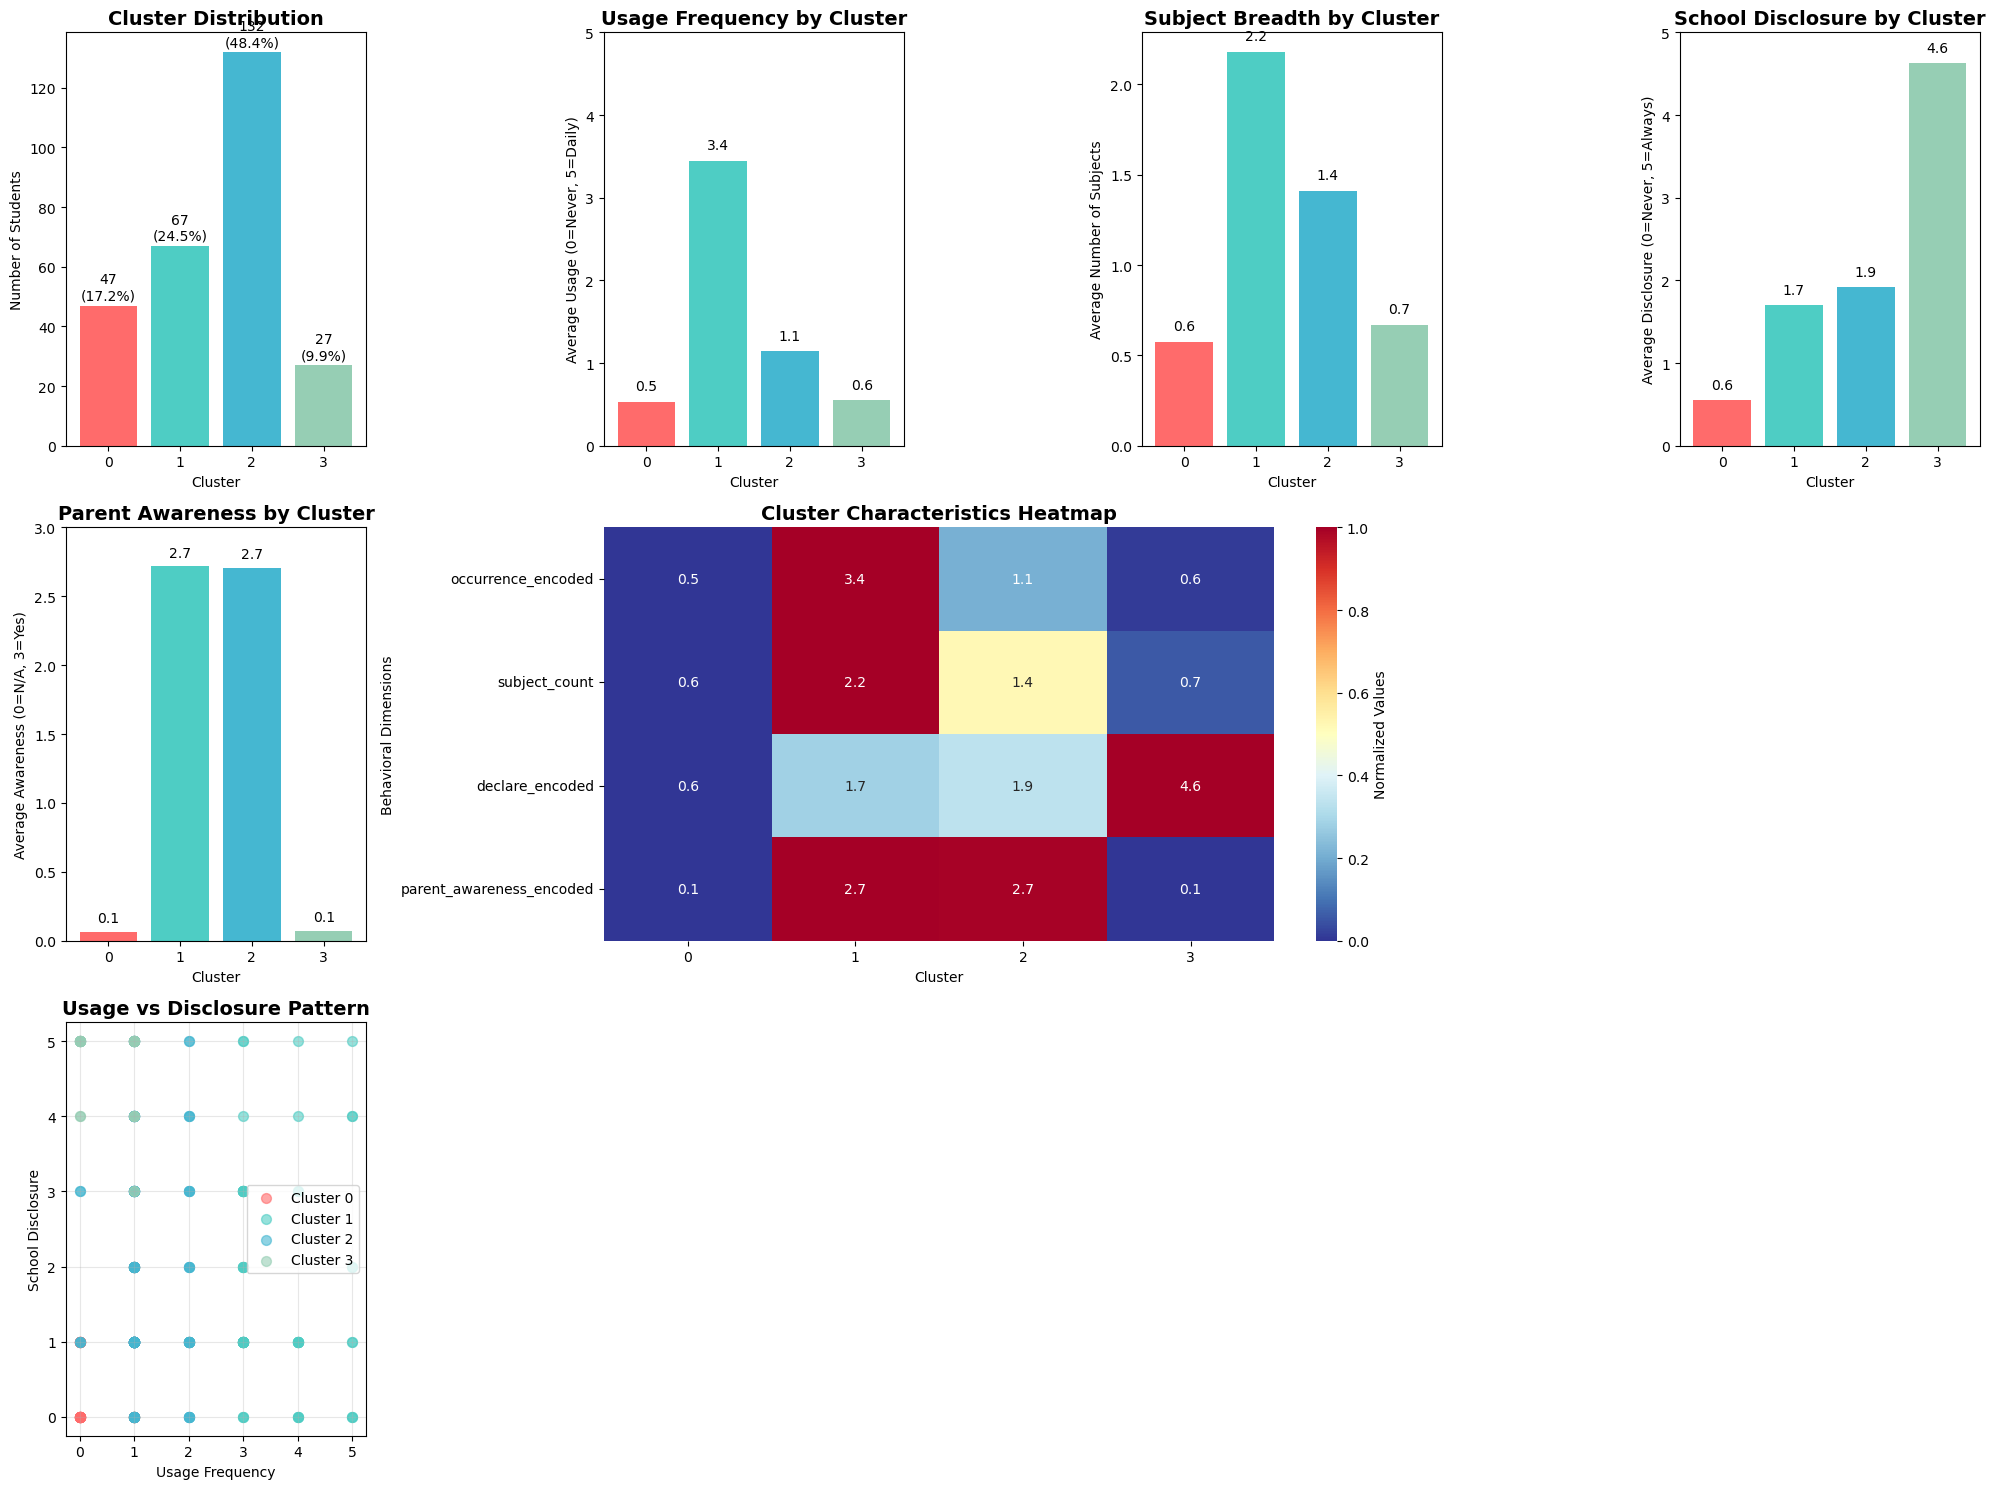

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive visualisation dashboard
fig = plt.figure(figsize=(20, 15))

# 1. Cluster size distribution
ax1 = plt.subplot(3, 4, 1)
cluster_counts = df['cluster'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax1.bar(cluster_counts.index, cluster_counts.values, color=colors)
ax1.set_title('Cluster Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Students')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{height}\n({height/273*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10)

# 2. Usage frequency by cluster
ax2 = plt.subplot(3, 4, 2)
cluster_usage = clustering_data.groupby('cluster')['occurrence_encoded'].mean()
bars = ax2.bar(cluster_usage.index, cluster_usage.values, color=colors)
ax2.set_title('Usage Frequency by Cluster', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Average Usage (0=Never, 5=Daily)')
ax2.set_ylim(0, 5)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 3. Number of subjects by cluster
ax3 = plt.subplot(3, 4, 3)
cluster_subjects = clustering_data.groupby('cluster')['subject_count'].mean()
bars = ax3.bar(cluster_subjects.index, cluster_subjects.values, color=colors)
ax3.set_title('Subject Breadth by Cluster', fontsize=14, fontweight='bold')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Average Number of Subjects')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 4. School disclosure by cluster
ax4 = plt.subplot(3, 4, 4)
cluster_declare = clustering_data.groupby('cluster')['declare_encoded'].mean()
bars = ax4.bar(cluster_declare.index, cluster_declare.values, color=colors)
ax4.set_title('School Disclosure by Cluster', fontsize=14, fontweight='bold')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Average Disclosure (0=Never, 5=Always)')
ax4.set_ylim(0, 5)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 5. Parent awareness by cluster
ax5 = plt.subplot(3, 4, 5)
cluster_parent = clustering_data.groupby('cluster')['parent_awareness_encoded'].mean()
bars = ax5.bar(cluster_parent.index, cluster_parent.values, color=colors)
ax5.set_title('Parent Awareness by Cluster', fontsize=14, fontweight='bold')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Average Awareness (0=N/A, 3=Yes)')
ax5.set_ylim(0, 3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.05, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 6-8. Heatmap of cluster characteristics
ax6 = plt.subplot(3, 4, (6, 7))
cluster_matrix = clustering_data.groupby('cluster')[['occurrence_encoded', 'subject_count', 
                                                     'declare_encoded', 'parent_awareness_encoded']].mean()
cluster_matrix_scaled = (cluster_matrix - cluster_matrix.min()) / (cluster_matrix.max() - cluster_matrix.min())

sns.heatmap(cluster_matrix_scaled.T, 
            annot=cluster_matrix.T, 
            cmap='RdYlBu_r', 
            ax=ax6,
            cbar_kws={'label': 'Normalised Values'},
            fmt='.1f')
ax6.set_title('Cluster Characteristics Heatmap', fontsize=14, fontweight='bold')
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Behavioral Dimensions')

# 9. Scatter plot of key dimensions
ax9 = plt.subplot(3, 4, 9)
for i, color in enumerate(colors):
    cluster_data = clustering_data[clustering_data['cluster'] == i]
    ax9.scatter(cluster_data['occurrence_encoded'], 
                cluster_data['declare_encoded'], 
                c=color, label=f'Cluster {i}', alpha=0.6, s=50)

ax9.set_xlabel('Usage Frequency')
ax9.set_ylabel('School Disclosure')
ax9.set_title('Usage vs Disclosure Pattern', fontsize=14, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Free text responses by cluster:

Cluster 0: 44 responses with text
Sample responses:
  1. Not really. I think that AI use should be limited and not encouraged by the school unless necessary....
  2. no...
  3. no...

Cluster 1: 62 responses with text
Sample responses:
  1. As annoying as it is, I think the current block of chatgpt on school wifi is a good idea - it means ...
  2. Should we be concerned if we are considering career paths where AI can take over?...
  3. Like I said before I think it has been very helpful for revision during the last few weeks....

Cluster 2: 124 responses with text
Sample responses:
  1. I am generally concerned about the accuracy of AI, particularly Chat GPT, in a maths and stem contex...
  2. ....
  3. On multiple occasions myself and others have been asked if our work is AI generated because of the l...

Cluster 3: 24 responses with text
Sample responses:
  1. Aim to discourage unnecessary AI usage, e.g. using Chat GPT rather than an internet browser 

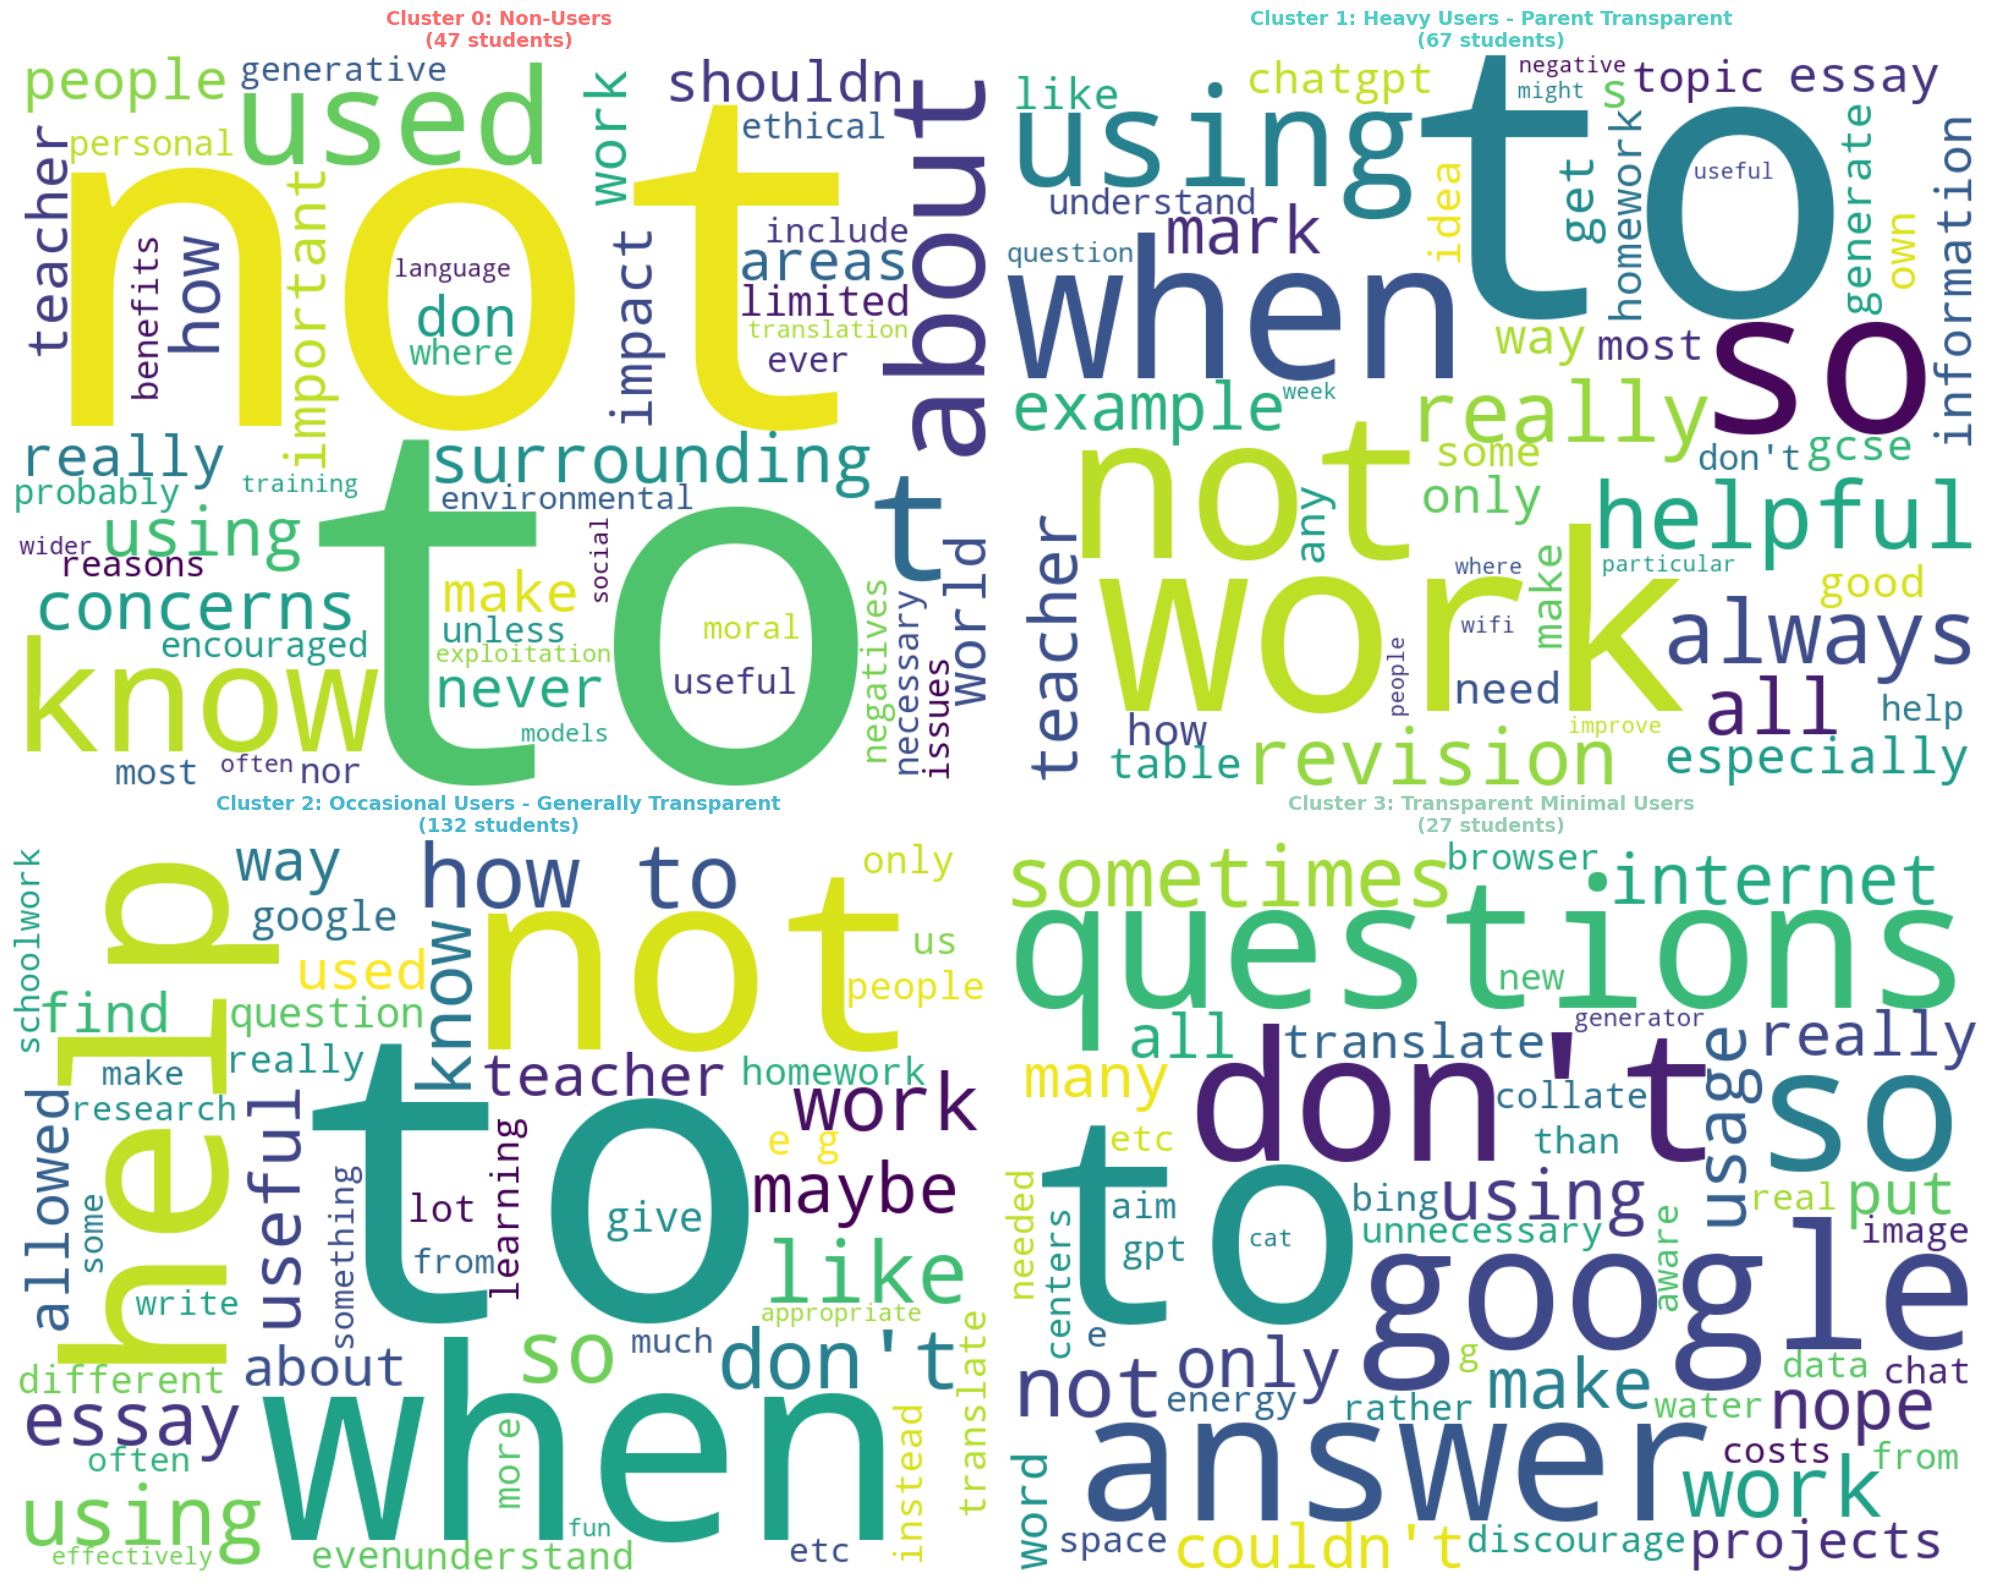

In [72]:
# First, let's examine what we have in the free text column
print("Free text responses by cluster:")
for cluster in range(6):
    cluster_responses = df[df['cluster'] == cluster]['Other_info'].dropna()
    print(f"\nCluster {cluster}: {len(cluster_responses)} responses with text")
    print("Sample responses:")
    for i, response in enumerate(cluster_responses.head(3)):
        print(f"  {i+1}. {response[:100]}...")

# Function to clean and prepare text for word clouds
def prepare_text_for_wordcloud(text_series):
    # Combine all text
    text = ' '.join(text_series.dropna().astype(str))
    
    # Basic cleaning
    text = text.lower()
    
    # Remove common stop words that aren't meaningful
    stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                  'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                  'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                  'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                  'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                  'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                  'while', 'of', 'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after',
                  'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                  'further', 'then', 'once', 'would', 'could', 'should', 'also', 'very', 'can', 'will',
                  'just', 'should', 'now', 'think', 'use', 'ai', 'tools', 'school', 'students', 'no'
                 }
    
    return text, stop_words

# Create word clouds for each cluster
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

cluster_names = [
    "Cluster 0: Non-Users",
    "Cluster 1: Heavy Users - Parent Transparent", 
    "Cluster 2: Occasional Users - Generally Transparent",
    "Cluster 3: Transparent Minimal Users"
]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i in range(4):
    cluster_text = df[df['cluster'] == i]['Other_info']
    text, stop_words = prepare_text_for_wordcloud(cluster_text)
    
    if len(text.strip()) > 0:
        wordcloud = WordCloud(width=800, height=600, 
                             background_color='white',
                             stopwords=stop_words,
                             max_words=50,
                             colormap='viridis',
                             relative_scaling=0.5,
                             min_font_size=10).generate(text)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{cluster_names[i]}\n({len(df[df["cluster"]==i])} students)', 
                         fontsize=14, fontweight='bold', color=colors[i])
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'No text responses\nin this cluster', 
                    ha='center', va='center', fontsize=16)
        axes[i].set_title(cluster_names[i], fontsize=14, fontweight='bold')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [73]:
# First, let's see what confidence responses we have
print("Confidence level responses:")
print(df['Confidence'].value_counts())
print("\nUnique values:")
print(df['Confidence'].unique())

# Encode confidence levels
def encode_confidence(value):
    confidence_map = {
        'Very confident': 4,
        'Quite confident': 3,
        'Somewhat confident': 2,
        'Not very confident': 1,
        'Not confident at all': 0
    }
    return confidence_map.get(value.strip(), None)

# Apply confidence encoding
df['confidence_encoded'] = df['Confidence'].apply(encode_confidence)

# Analyse confidence by cluster
confidence_by_cluster = df.groupby('cluster')['confidence_encoded'].agg(['mean', 'std', 'count']).round(2)
print("\nConfidence by Cluster:")
print(confidence_by_cluster)

# Create detailed breakdown
print("\n" + "="*60)
print("CONFIDENCE ANALYSIS BY CLUSTER:")
print("="*60)

cluster_names = [
    "Thoughtful Skeptics",
    "Pragmatic Power Users", 
    "Cautious Experimenters",
    "Rule-Followers"
]

for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    confidence_dist = cluster_data['Confidence'].value_counts()
    mean_confidence = cluster_data['confidence_encoded'].mean()
    
    print(f"\n🔍 {cluster_names[cluster_id]} (Cluster {cluster_id}):")
    print(f"  • Average Confidence: {mean_confidence:.2f}/4")
    print(f"  • Confidence Distribution:")
    for conf_level, count in confidence_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"    - {conf_level}: {count} students ({percentage:.1f}%)")

Confidence level responses:
Confidence
Somewhat confident                                           135
 Very confident                                               69
Unsure what "effective and ethical" means in this context     35
Not very confident                                            25
Not confident at all                                           9
Name: count, dtype: int64

Unique values:
[' Very confident' 'Somewhat confident' 'Not very confident'
 'Unsure what "effective and ethical" means in this context'
 'Not confident at all']

Confidence by Cluster:
         mean   std  count
cluster                   
0        2.18  0.97     34
1        2.73  1.20     64
2        2.37  1.04    116
3        1.96  1.30     24

CONFIDENCE ANALYSIS BY CLUSTER:

🔍 Thoughtful Skeptics (Cluster 0):
  • Average Confidence: 2.18/4
  • Confidence Distribution:
    - Somewhat confident: 23 students (48.9%)
    - Unsure what "effective and ethical" means in this context: 13 students (27.7%)
 